In [1]:
import pandas as pd
import numpy as np
import pickle
from selenium import webdriver
import os
import time
from bs4 import BeautifulSoup
import seaborn as sns

%pylab inline
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# 1. Load Data

In [2]:
_2019 = pd.read_excel('../data/external/2019-Report-Card-Public-Data-Set.xlsx', sheet_name=None)

In [3]:
_2018 = pd.read_excel('../data/external/2018-Report-Card-Public-Data-Set.xlsx', sheet_name=None)

In [4]:
print(len(_2019['Financial'].columns))
print(len(_2018['Financial'].columns))

69
49


In [5]:
[x for x in _2018['Financial'].columns if '2016' not in x]

['RCDTS',
 'Type',
 'District',
 'City',
 'County',
 'District Type',
 'District Size',
 'EBF Tier',
 'EBF Capacity to Meet Expectations']

In [6]:
def get_columns_to_omit(df1, df2):
    col_intersection = set(df1.columns).intersection(set(df2.columns))
    col_intersection.remove('RCDTS')
    return list(col_intersection)

def merge_gen_fin_sat(dfs):
    gen = dfs['General']
    fin = dfs['Financial']
    sat = dfs['SAT']
    
    gen_fin = gen.merge(fin.drop(columns=get_columns_to_omit(gen, fin)), on="RCDTS", how="left")
    return gen_fin.merge(sat.drop(columns=get_columns_to_omit(gen_fin, sat)), on="RCDTS", how="left")
    

In [7]:
merged_2019 = merge_gen_fin_sat(_2019)
merged_2018 = merge_gen_fin_sat(_2018)

In [8]:
merged_2018.columns = [x.strip() for x in merged_2018.columns]
merged_2019.columns = [x.strip() for x in merged_2019.columns]

In [9]:
columns_difference = list(set(merged_2019.columns) - set(merged_2018.columns))
sorted(list(columns_difference))
# Glanced through columns that are different across both data sets and I believe I can drop them all
# except need to map school enrollment
len(columns_difference)

855

In [10]:
enroll_col_names_2018 = [x for x in merged_2018.columns if 'Enrollment' in x]
enroll_col_names_2019 = [x for x in merged_2019.columns if 'Enrollment' in x]
matched = enroll_col_names_2019[:-1]
matched.remove('% Student Enrollment - Children with Disabilities')

enroll_field_map_2018_to_2019 = dict(zip(enroll_col_names_2018,matched))

In [11]:
other_fields_2018_to_2019 = {
    'Total Students SAT Math Participation': '# Students SAT Math Participation',
    'Total Students SAT Math Participation %': '% Students SAT Math Participation',
    'Total Students SAT ELA Participation': '# Students SAT ELA Participation',
    'Total Students SAT ELA Participation %': '% SAT ELA Participation',
    'Five Essential Survey Student Response Rate %': 'Five Essential Survey Student Response Rate',
    'Five Essential Survey Teacher Response Rate %': 'Five Essential Survey Teacher Response Rate',
    'EBF Capacity to Meet Expectations': '% EBF Capacity to Meet Expectations'
}

def map_col_names_2018_2019(column_name_2018):
    if column_name_2018 in enroll_field_map_2018_to_2019:
        return enroll_field_map_2018_to_2019[column_name_2018]
    if column_name_2018 in other_fields_2018_to_2019:
        return other_fields_2018_to_2019[column_name_2018]
    return column_name_2018

merged_2018.columns = [map_col_names_2018_2019(x) for x in merged_2018.columns]

In [12]:
# _2017 = pd.read_csv('../data/external/rc17_assessment.txt', sep=';', header=None)
# 2017 data is raw, semi-colon delimited text files. Has a corresponding map to get column names
# Ignoring for now

In [13]:
print(merged_2018.shape, merged_2019.shape)

(4754, 604) (4738, 1124)


In [14]:
merged_2019['Year'] = 2019
merged_2018['Year'] = 2018
_18_19 = merged_2019.append(merged_2018, sort=False).reset_index()

In [15]:
_18_19.shape

(9492, 1441)

In [16]:
_18_19.to_csv('../data/interim/raw_18_19.csv')

In [15]:
merged_2019.to_csv('../data/interim/merged_19.csv')

In [16]:
merged_2018.to_csv('../data/interim/merged_19.csv')

# 2. Explore Data

In [103]:
for col in _18_19.columns:
    print(col)

index
RCDTS
Type
School Name
District
City
County
District Type
District Size
School Type
Grades Served
Summative Designation
Summative Designation: Student Group(s)
Title 1 Status
State Senate District
State Representative District
# Student Enrollment
% Student Enrollment - White
% Student Enrollment - Black or African American
% Student Enrollment - Hispanic or Latino
% Student Enrollment - Asian
% Student Enrollment - Native Hawaiian or Other Pacific Islander
% Student Enrollment - American Indian or Alaska Native
% Student Enrollment - Two or More Races
% Student Enrollment - Children with Disabilities
% Student Enrollment - EL
% Student Enrollment - IEP
% Student Enrollment - Low Income
% Student Enrollment - Homeless
Total Number of School Days
% 8th Grade Passing Algebra 1
Student Attendance Rate
Student Mobility Rate
Student Mobility Rate - Male
Student Mobility Rate - Female
Student Mobility Rate - White
Student Mobility Rate - Black or African American
Student Mobility Rate 

#### Stuff it does have
- RCDTS - perhaps a unique identifier
- basic location data (county, city, district, school name)
- seems like it is for each school (3563 unique school name fields)
School       3872
District      865
Statewide       1
Name: Type, dtype: int64
- racial make up of the students
- extenuating circumstances (EL, IEP - broken down by type/need/dmo, Low Income, Homeless)
- attendence (# of days, attendence, truancy, chronic absenteeism)
- mobility rates for various demographics
- dropout rates for various demographics
- 4/5/6 year graduation rates
- Avg class size - all grades
- Min per day math/eng/social studies by grade (also phys ed)
- teacher info (total fte, race, gender, edu, novice, prov/short term license, retention, attendence, eval, salary, pupil teacher ratio)
- admin info (principal turnover, admin ratio, admin salary)
- 9th grade on track (by demo)
- student activies (CTE, advanced courses, AP/IB/Dual Credit - by demo and grade - enroll and test)
- enrolled in postsecondary (by demo, community college)
- survey data (leaders, involved families, ambitions instr, supportive, resp rate)
- Disciplinary info (total enrollment, suspensions, expulsions, arrests, law enf, violency
- demo info on "peer" districts 
- early childhood edu info
- state performance plan indicators (district, target, whether met taret)

#### Scrapable data has

Spending info
- Instructional Spending per Student ($)',
       'Operational Spending per Student ($)', 'Local Property Taxes (%)',
       'Other Local Funding (%)', 'Evidence-Based Funding (%)',
       'Other State Funding (%)', 'Federal Funding (%)', 'Total Revenue',
       (2018 on for below)
       'EBF Adequacy Target ($)',
       'EBF Capacity To Meet Funding Expectation (%)',
       'EBF Local Capacity Target ($)', 'EBF Real Receipts ($)',
       'EBF Local Capacity Target (%)', 'EBF Real Receipts (%)',
       'ESSA Designation'
- Feeder Schools (2018 on):
'ESSA Designation', 'ESSA Exemplary Schools',
       'ESSA Commendable Schools', 'ESSA Under Performing Schools',
       'ESSA Lowest Performing Schools', 'Has Feeder Schools',
- Overall Designation:


#### Stuff it doesn't have

- expenditure info
- growth in reading/math
- % evidence based funding formula
- feeder school ratings


In [147]:
relevant_columns = [
    'RCDTS',
    'Type',
    'School Name',
    'District',
    'City',
    'County',
    'District Type',
    'District Size',
    'School Type',
    'Grades Served',
    'Summative Designation',
    '# Student Enrollment',
    '% Student Enrollment - White',
    '% Student Enrollment - Black or African American',
    '% Student Enrollment - Hispanic or Latino',
    '% Student Enrollment - Asian',
    '% Student Enrollment - Native Hawaiian or Other Pacific Islander',
    '% Student Enrollment - American Indian or Alaska Native',
    '% Student Enrollment - Two or More Races',
#     '% Student Enrollment - Children with Disabilities', -> not in 2018
    '% Student Enrollment - EL',
    '% Student Enrollment - IEP',
    '% Student Enrollment - Low Income',
    '% Student Enrollment - Homeless',
    'Total Number of School Days',
    'Student Attendance Rate',
    'Student Mobility Rate',
    'High School Dropout Rate - Total',
    'High School 4-Year Graduation Rate - Total',
    'High School 6-Year Graduation Rate - Total',
    'Avg Class Size – All Grades',
    'Total Teacher FTE',
    'Avg Teaching Exp',
    'Bachelor Degree',
    'Masters Degree',
#     '% Novice Teachers', -> not in 2018
#     '% Novice Teachers - Low Poverty Schools',
    'Teacher Retention Rate',
    'Teacher Attendace Rate',
    'Teacher Evaluation Rate',
    'Principal Turnover within 6 Years',
    'Pupil Teacher Ratio - Elementary',
    'Pupil Teacher Ratio - High School',
    'Pupil Certified Staff Ratio',
    'Pupil Admin Ratio',
    'Teacher Avg Salary',
    'Admin Avg Salary',
    'Five Essential Survey Effective Leaders',
    'Five Essential Survey Leaders Level',
    'Five Essential Survey Collaborative Teachers',
    'Five Essential Survey Collaborative Teachers Level',
    'Five Essential Survey Involved Families',
    'Five Essential Survey Involved Families Level',
    'Five Essential Survey Supportive Environment',
    'Five Essential Survey Supportive Environment Level',
    'Five Essential Survey Ambitious Instruction',
    'Five Essential Survey Ambitious Instruction.1',
#     'Five Essential Survey Student Response Rate', -> not in 2018
#     'Five Essential Survey Teacher Response Rate',
#     'Five Essential Survey Schools with over 50% Response Rate',
    'Five Essential Survey Student Response Rate Median',
    'Five Essential Survey Teacher Response Rate Median',
#     '# CRDC Total Enrollment', -> nothing in 2018 with CRDC
    'EBF Tier',
    '% EBF Capacity to Meet Expectations',
#     '$ Site-Level Per-Pupil Expenditures - Federal',
#     '$ Site-level Per-Pupil Expenditures - State/Local',
#     '$ Site-level PEr-Pupil Expenditures - Subtotal',
#     '$ District Centralized Per-Pupil Expenditure - Federal',
#     '$ District Centralized Per-Pupil Expenditure - State/Local',
#     '$ District Centralized Per-Pupil Expenditure - Subtotal',
#     '$ Total Per-Pupil Expenditures - Federal',
#     '$ Total Per-Pupil Expenditures - State/Local',
#     '$ Total Per-Pupil Expenditures - Subtotal',
#     '$ Exclusions',
#     '$ Total Expenditures',
    'SAT Reading Total Students Level 1 %',
    'SAT Reading Total Students Level 2 %',
    'SAT Reading Total Students Level 3 %',
    'SAT Reading Total Students Level 4 %',
    'SAT Math Total Students Level 1 %',
    'SAT Math Total Students Level 2 %',
    'SAT Math Total Students Level 3 %',
    'SAT Math Total Students Level 4 %',
    '# Students SAT Math Participation',
    '% Students SAT Math Participation',
    '# Students SAT ELA Participation',
    '% SAT ELA Participation',
    'Year',
]

### Are they in both?

In [148]:
rel = set(relevant_columns)
col_in_2019 = set(merged_2019.columns)
col_in_2018 = set(merged_2018.columns)

In [149]:
rel - col_in_2019

set()

In [150]:
rel - col_in_2018

set()

In [151]:
subset = _18_19.loc[:, relevant_columns]

In [152]:
subset.shape

(9492, 71)

In [154]:
subset.to_csv('../data/interim/2018-19_relevant_columns.csv')

# 3. Data Exploration

In [232]:
subset = pd.read_csv('../data/interim/2018-19_relevant_columns.csv')

In [233]:
subset.Type.value_counts()

School       7760
District     1730
Statewide       2
Name: Type, dtype: int64

In [234]:
schools = subset[subset.Type == 'School']

In [235]:
schools = schools.dropna(subset=['Grades Served']).reset_index()
# one school doesn't specify which grades they serve

In [236]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7759 entries, 0 to 7758
Data columns (total 73 columns):
index                                                               7759 non-null int64
Unnamed: 0                                                          7759 non-null int64
RCDTS                                                               7759 non-null object
Type                                                                7759 non-null object
School Name                                                         7759 non-null object
District                                                            7759 non-null object
City                                                                7759 non-null object
County                                                              7759 non-null object
District Type                                                       7746 non-null object
District Size                                                       7735 non-null object
Schoo

In [237]:
high_schools = schools[schools['Grades Served'].str.contains('12', na=False)]

In [238]:
high_schools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1441 entries, 0 to 7740
Data columns (total 73 columns):
index                                                               1441 non-null int64
Unnamed: 0                                                          1441 non-null int64
RCDTS                                                               1441 non-null object
Type                                                                1441 non-null object
School Name                                                         1441 non-null object
District                                                            1441 non-null object
City                                                                1441 non-null object
County                                                              1441 non-null object
District Type                                                       1433 non-null object
District Size                                                       1425 non-null object
Schoo

In [239]:
features = [
    '# Student Enrollment',
    '% Student Enrollment - Low Income',
    'Avg Class Size – All Grades',
    'Teacher Retention Rate',
    'Principal Turnover within 6 Years',
    '% EBF Capacity to Meet Expectations',
    'High School 4-Year Graduation Rate - Total'
]


just_features = high_schools[features].dropna(subset=features)

In [240]:
just_features.shape

(688, 7)

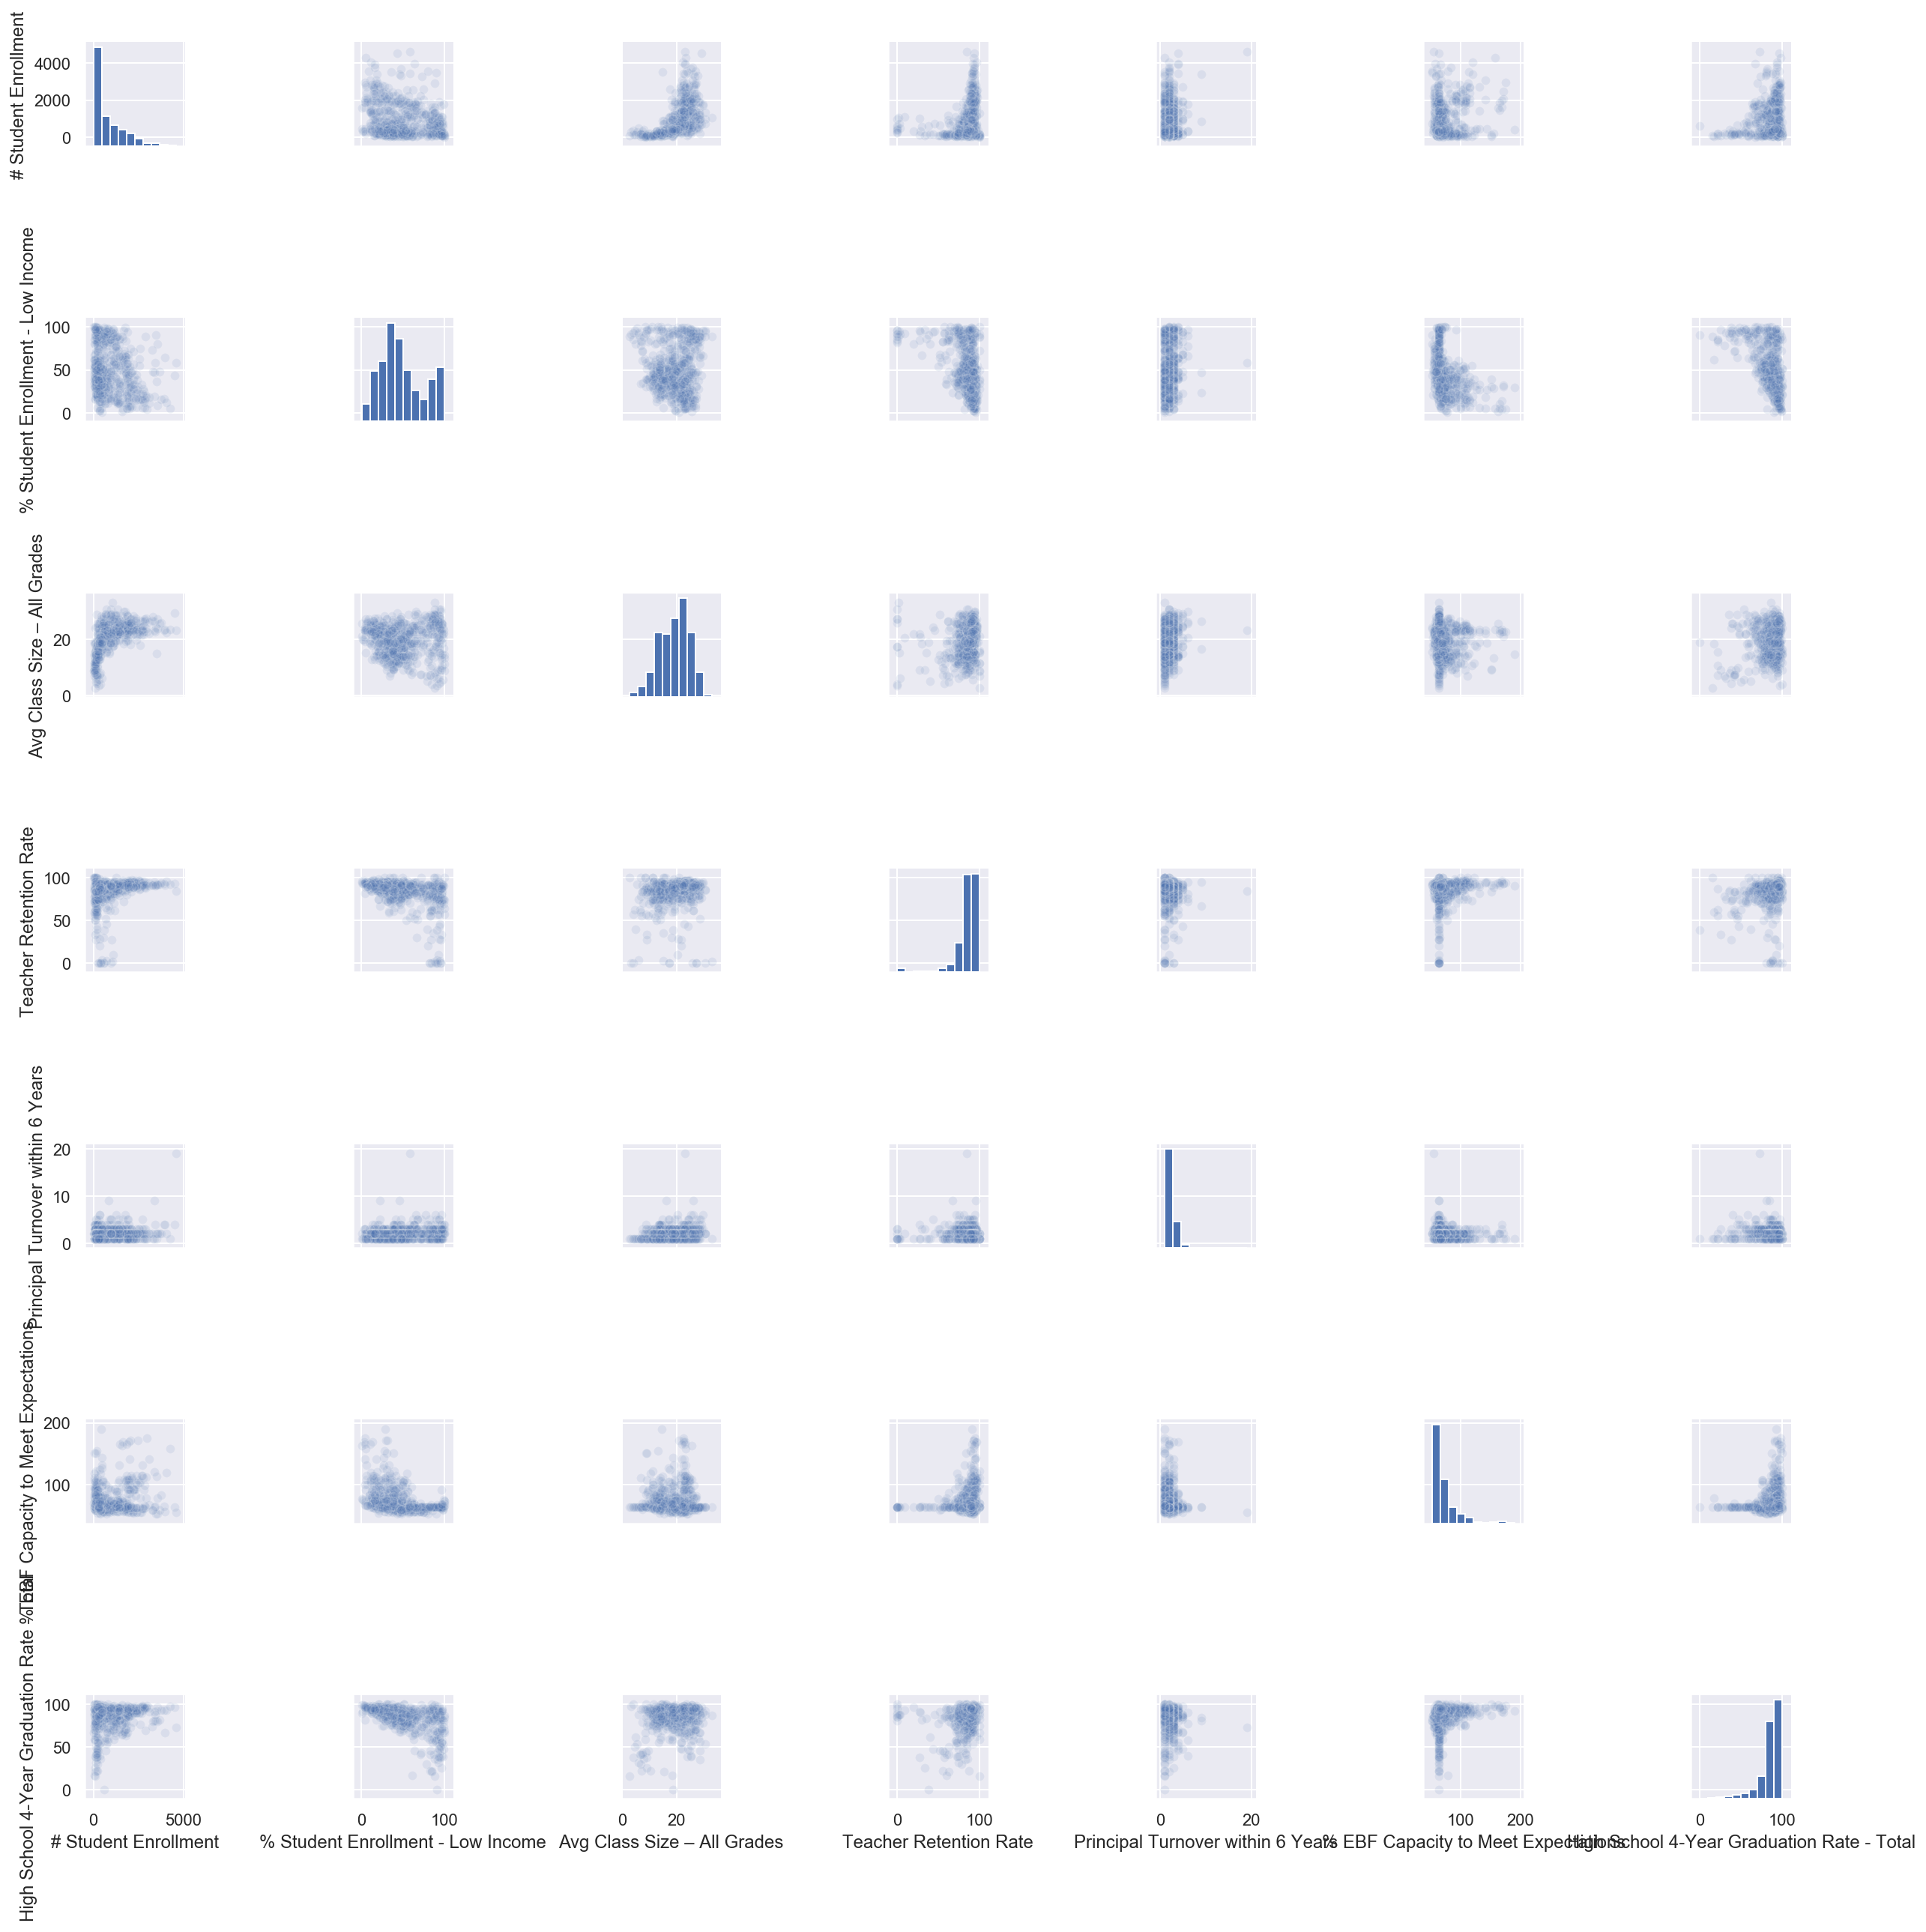

In [241]:
sns.pairplot(just_features, plot_kws={'alpha': 0.1})

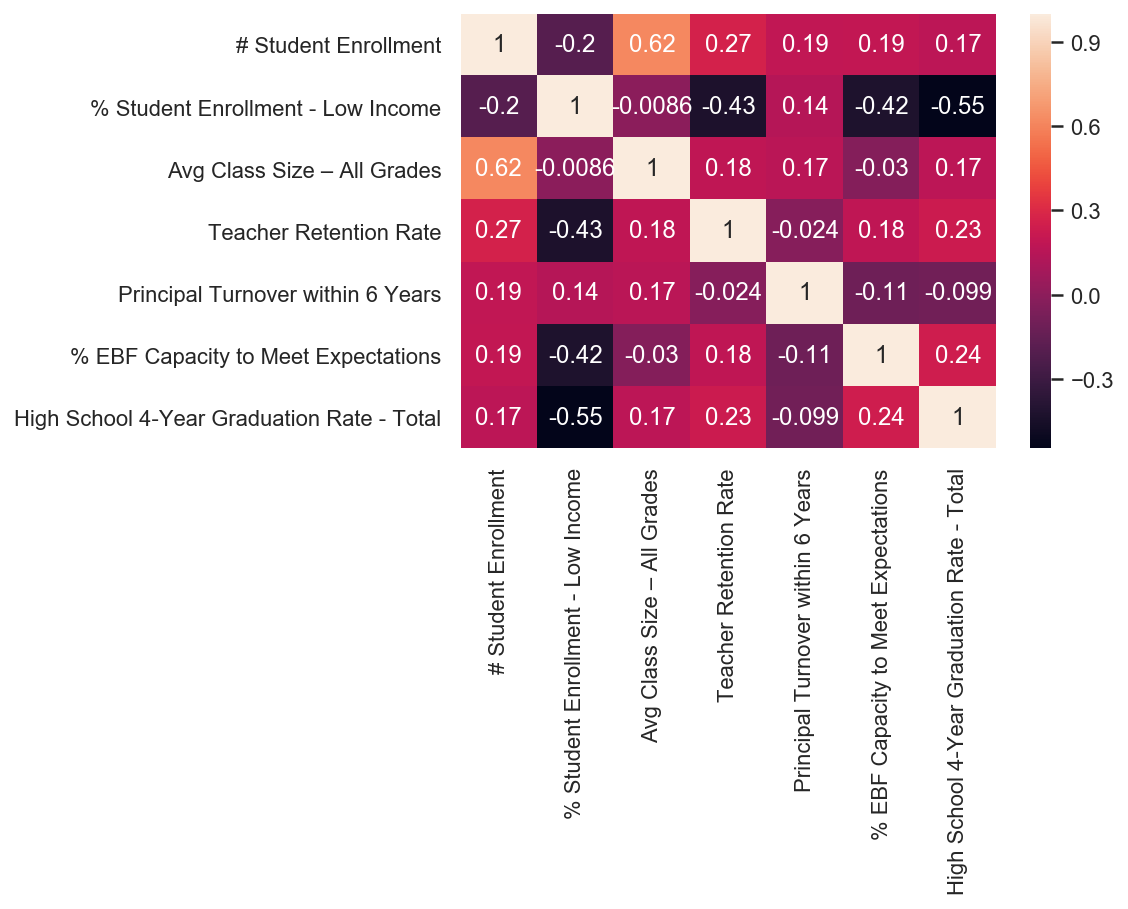

In [242]:
sns.heatmap(just_features.corr(), annot=True)

In [243]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 

In [244]:
X = just_features.iloc[:, :-1]
y = just_features.iloc[:, -1]

In [245]:
split_and_validate(X, y)


Validation R^2 score was: 0.28242214918786157
Feature coefficient results: 

# Student Enrollment : -0.00
% Student Enrollment - Low Income : -0.30
Avg Class Size – All Grades : 0.62
Teacher Retention Rate : 0.02
Principal Turnover within 6 Years : -0.39
% EBF Capacity to Meet Expectations : 0.02


In [248]:
just_features = just_features.rename(columns={
    'High School 4-Year Graduation Rate - Total': 'grad_rate',
    '# Student Enrollment': 'enrollment',
    '% Student Enrollment - Low Income': 'low_inc_perc',
    'Avg Class Size – All Grades': 'avg_class_size',
    'Teacher Retention Rate': 'teach_retention',
    'Principal Turnover within 6 Years': 'principle_turnover',
    '% EBF Capacity to Meet Expectations': 'ebf_capacity',
})

In [249]:
# just_features.columns = [x.replace('_', ' ').lower() for x in just_features.columns]
# Define the model
X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)

y_name = just_features.columns[-1]
x_eqn = ' + '.join(just_features.columns[:-1])
lm1 = smf.ols(f'{y_name} ~ {x_eqn}', data=just_features)

# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              grad_rate   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     56.73
Date:                Wed, 15 Jan 2020   Prob (F-statistic):           7.45e-57
Time:                        19:16:16   Log-Likelihood:                -2643.7
No. Observations:                 688   AIC:                             5301.
Df Residuals:                     681   BIC:                             5333.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             91.6221      4.184     21.897      0.000      83.406      99.838
enrollment            -0.0011      0.001     -1.675      0.094      -0.002       0.000
low_inc_perc          -0.2973      0.020    -14.587      0.000      -0.337      -0.257
avg_class_size         0.5683      0.104      5.472      0.000       0.364       0.772
teach_retention       -0.0345      0.032     -1.080      0.281      -0.097       0.028
principle_turnover    -0.4503      0.370     -1.218      0.223      -1.176       0.275
ebf_capacity           0.0223      0.025      0.906      0.365      -0.026       0.071
==============================================================================
Omnibus:                      274.875   Durbin-Watson:                   1.446
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1717.677
Skew:                          -1.666   Prob(JB):                         0.00
Kurtosis:                       9.987   Cond. No.                     1.18e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
just_features.describe()

In [ ]:
just_features.columns

In [ ]:
new_columns = ['enrollment', 'low_inc_perc', 'avg_class_size', 'teach_retention', 'princ_turnover', 'ebf_capacity', 'grad_rate']

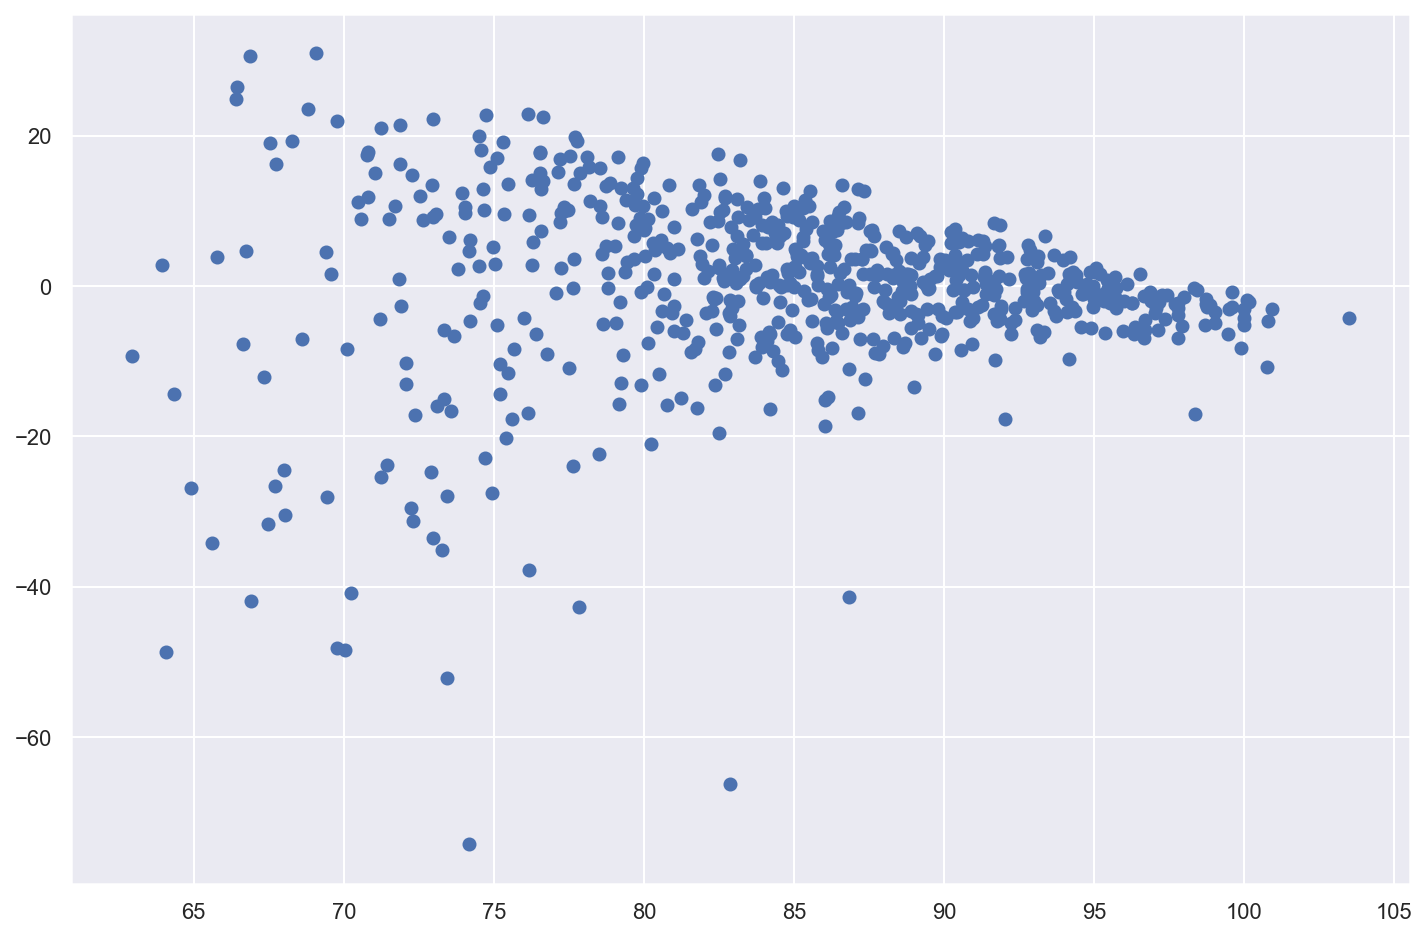

In [252]:
plt.figure(figsize=(12,8))
plt.scatter(fit1.predict(), fit1.resid);